Inicio

Notas: 
-#gnsim: esto es para el LDA. o le preguntamos 

In [0]:
#Ejecutar y reiniciar entorno
pip install --user lightgbm==2.1.1

In [0]:
#Para tratar el codigo postal
# Geocoding library 
!pip install geopy
# Install folium
!pip install folium
#install feature selector
!pip install git+https://github.com/WillKoehrsen/feature-selector.git


  Cloning https://github.com/WillKoehrsen/feature-selector.git to /tmp/pip-req-build-uxuchkwh
  Running command git clone -q https://github.com/WillKoehrsen/feature-selector.git /tmp/pip-req-build-uxuchkwh
  Created wheel for feature-selector: filename=feature_selector-N_A-cp36-none-any.whl size=20721 sha256=f4d9f220c1d7030af0cc79108a539ee437b223bb45fcce617c32187a9d9f8199
  Stored in directory: /tmp/pip-ephem-wheel-cache-az4z9u07/wheels/d5/67/b5/319a9229365dd4958877b18a9b31315c9f31e85c5a5bbcf7ff
Successfully built feature-selector


In [0]:
#Importar librerias
import pandas as pd
import numpy as np
from statistics import mean 
import datetime 

import matplotlib.pyplot as plt
import seaborn as sns


from geopy.geocoders import Nominatim

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score

Leer archivos de excel 

In [0]:
#Obtener permisos de google drive
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [0]:
#Leer el spreadsheet del formulario de respuesta
workbook = gc.open_by_url('https://docs.google.com/spreadsheets/d/1nAlzYGwHNv0gaFnobJN8b_sViFGxeRUbqikA1YojWcU/edit#gid=196546652')

#Leer la pestaña y traer todos los datos
sheet = workbook.worksheet('Form Responses 1')
dataFromForm = sheet.get_all_values()

In [0]:
#Leer el spreadsheet de datos intermedios
workbook = gc.open_by_url('https://docs.google.com/spreadsheets/d/1fcFawoIqKNUhrLfUgrggzdm0Scl-5_u_gfXBX_IQ5EY/edit#gid=206785808')

#Leer la pestaña y traer todos los datos de metada de preguntas psicopoliticas
sheet = workbook.worksheet('CategoriasPreguntas')
dataQuestions = sheet.get_all_values()

#Leer la pestaña y traer todos los datos de metadata de las propuesta de ley
sheet = workbook.worksheet('PropuestaDeLey')
dataLawProposals = sheet.get_all_values()

#Leer la pestaña y traer todos los datos de metadata de las categorias
sheet = workbook.worksheet('Categorias')
dataCategories = sheet.get_all_values()

#Leer la pestaña y traer todos los datos de metadata de las propuesta de ley que usaremos para predecir
sheet = workbook.worksheet('PropuestaPrecedir')
dataLawProposalsPredict = sheet.get_all_values()


Corres para los cuales queremos predecir

In [0]:
#correos para los cuales vamos a predecir las nuevas propuestas de ley
correosPredecir = ['dmedina82@gmail.com','f.gar.garcia@gmail.com','ucone92@mail.com','laseiras@gmail.com']

Montar los Dataset

In [0]:
#columnas a siempre eliminar
columnsToDelete = ['Timestamp',
                   '¿Cómo de útil sería para ti esta información? [Qué partido realiza la Proposición de Ley]',
                   '¿Cómo de útil sería para ti esta información? [Qué partidos votan a favor y en contra de cada proposición]',
                   '¿Cómo de útil sería para ti esta información? [Cómo encaja cada Proposición con mi postura política]',
                   '¿Cómo de útil sería para ti esta información? [Qué opinan otras organizaciones sobre cada propuesta de ley (Empresariales, Ecologistas, Sindicatos, ONG... afectadas por a propuesta)]',
                   '¿Cómo de útil sería para ti esta información? [Leer/participar en argumentaciones estructuradas  a favor y en contra de cada propuesta de ley]',
                   '¿Cómo de útil sería para ti esta información? [Comparación entre propuestas electorales de cada partido y su postura real en las propuestas de ley]',
                   'Si quieres pedirnos más información para que te la enviemos, o tienes cualquier otra sugerencia o comentario, cuéntanos aquí:',
                   '¿Cómo de importantes son para ti cada uno de los aspectos que se evalúan? [Descentralización del Estado]',
                   '¿Cómo de importantes son para ti cada uno de los aspectos que se evalúan? [Economía Liberal]',
                   '¿Cómo de importantes son para ti cada uno de los aspectos que se evalúan? [Política fiscal restrictiva]',
                   '¿Cómo de importantes son para ti cada uno de los aspectos que se evalúan? [Ley y orden]',
                   '¿Cómo de importantes son para ti cada uno de los aspectos que se evalúan? [Unidad de España]',
                   '¿Cómo de importantes son para ti cada uno de los aspectos que se evalúan? [Protección del Medio Ambiente]',
                   '¿Cómo de importantes son para ti cada uno de los aspectos que se evalúan? [Estado del bienestar]',
                   '¿Cómo de importantes son para ti cada uno de los aspectos que se evalúan? [Libertades Civiles y sociedad liberal]',
                   '¿Cómo situarías tu situación económica en esta escala?',
                   '¿Con qué partido o partidos políticos te sientes más identificado? [Segundo más identificado]',
                   '¿Con qué partido o partidos políticos te sientes más identificado? [Tercero más identificado]',
                   'En caso de ver informativos en la televisión, ¿podrías indicarnos en qué cadena(s) los sueles ver? [A veces lo veo en]'
                   ]

In [0]:
#columnas a siempre cambiar nombre
columnsToRename = {'Año de nacimiento':'AñoNacimiento',
                   'Lugar de residencia (Código Postal)':'CodigoPostal',
                   #['Sexo':'Sexo',
                   'Máximo nivel de estudios alcanzado':'Estudios',
                   'Estado Civil':'EstadoCivil',
                   'País de nacimiento':'Pais',
                   'Déjanos tu correo electrónico para que podamos crearte un usuario:':'Correo',
                   '¿Con qué partido o partidos políticos te sientes más identificado? [Más identificado]':'Partido1',
                   #'¿Con qué partido o partidos políticos te sientes más identificado? [Segundo más identificado]':'Partido2',
                   #'¿Con qué partido o partidos políticos te sientes más identificado? [Tercero más identificado]':'Partido3',
                   'En caso de ver informativos en la televisión, ¿podrías indicarnos en qué cadena(s) los sueles ver? [Suelo verlo en]':'Informativos1',
                   #'En caso de ver informativos en la televisión, ¿podrías indicarnos en qué cadena(s) los sueles ver? [A veces lo veo en]':'Informativos2',
                   'Cuando se habla de política, a veces se utiliza la referencia de "izquierda" y "derecha" para reflejar preferencias ideológicas. En esta escala, ¿dónde te situarías tú?':'Ideologia',
                   '¿Dónde situarías tu nivel de renta y patrimonio, considerando en conjunto el personal y el familiar?':'RentaTotal'}

In [0]:
columnsToInt = ['Form1','Form2','Form3','Form4','Form5','Form6','Form7','Form8','Form9','Form10','Form11','Form12','Form13','Form14','Form15','Form16','Form17','Form18','Form19','Form20','Form21','Form22','Form23',
                   'AñoNacimiento','Ideologia','RentaTotal']
columnsToString = ['CatForm1','CatForm2','CatForm3','CatForm4','CatForm5','CatForm6','CatForm7','CatForm8','CatForm9','CatForm10','CatForm11','CatForm12','CatForm13','CatForm14','CatForm15','CatForm16','CatForm17','CatForm18','CatForm19','CatForm20','CatForm21','CatForm22','CatForm23',
                   'CodigoPostal','Sexo','Estudios','EstadoCivil','Pais','Partido1','Partido2','Partido3','Informativos1','Informativos2','RentaTotal']

In [0]:
#crear el dataset principal a partir del excel del formulario y ajustar columnas y filas
df = pd.DataFrame(dataFromForm)
df.columns = df.iloc[0]
df = df.iloc[1:]

In [0]:
#eliminar las primeras columnas definidas
df.drop(columnsToDelete, axis=1, inplace=True)

In [0]:
#cambiar de nombres las columnas definidas
df.rename(columns=columnsToRename,inplace=True)

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 1 to 76
Data columns (total 40 columns):
 #   Column                                                                                                                                                      Non-Null Count  Dtype 
---  ------                                                                                                                                                      --------------  ----- 
 0   La educación y la sanidad deberían ser competencias del estado central y dejar de serlo de las autonomías.                                                  76 non-null     object
 1   El Estado central debería ceder a las Comunidades Autónomas la recaudación de la mayoría de los impuestos.                                                  76 non-null     object
 2   En algunos casos, la sanidad pública debería ser gestionada por empresas privadas.                                                                          

In [0]:
df.tail()

,La educación y la sanidad deberían ser competencias del estado central y dejar de serlo de las autonomías.,El Estado central debería ceder a las Comunidades Autónomas la recaudación de la mayoría de los impuestos.,"En algunos casos, la sanidad pública debería ser gestionada por empresas privadas.","No se debería subir el salario mínimo, ya que perjudicaría el mercado laboral.","La gestación subrogada (""vientres de alquiler"") debería ser legalizada y regulada.","Es necesario aumentar el gasto público en educación, aunque ello supusiera una subida de impuestos o reducir el gasto en otras áreas.",Se deben aumentar las prestaciones económicas por desempleo de los ciudadanos.,Es necesario seguir aumentando la edad de jubilación para garantizar la sostenibilidad del sistema público de pensiones.,El gobierno debería controlar más las fronteras para combatir la inmigración ilegal.,La prisión permanente revisable debería contemplarse para algunos delitos muy graves.,"En algunos casos, es importante limitar el derecho a manifestación para garantizar el orden público.",La legislación sobre el aborto debería ser más restrictiva.,La eutanasia debe ser legalizada en determinados casos.,"Las decisiones políticas deberían ser consultadas a la ciudadanía mediante procesos participativos (como referéndums, por ejemplo).","El gobierno debe priorizar la reducción del déficit, aunque eso suponga una reducción del gasto público.",Hay que reducir los impuestos que se aplican a las grandes empresas.,Las personas que más recursos tienen deberían pagar más para asegurar una mayor redistribución de la riqueza en el país.,"Se debe fomentar el transporte público por medio de impuestos (los llamados impuestos verdes, por ejemplo, las tasas por el uso de carreteras).",El medio ambiente debe protegerse aunque sea perjudicial para el crecimiento económico.,"El estado debería invertir más en energías renovables, aunque ello supusiera una subida de impuestos.","Las Comunidades deberían tener derecho a decidir en referéndum el tipo de relación que quieren con el Estado español (como por ejemplo, la independencia).","En Cataluña, Galicia y País Vasco, las lenguas co-oficiales deben fomentarse en la escuela de forma prioritaria para compensar el dominio del español.","Se deberían ilegalizar aquellos partidos, asociaciones u ONGs que persigan la destrucción de la unidad territorial de la Nación.",Legalización de la eutanasia,Neutralidad ideológica en las Universidades,Derogación del Impuesto de Patrimonio,Prohibición del fracking,Equiparación y ampliación de los derechos de maternidad y paternidad,Medidas para el fomento del autoconsumo eléctrico de cualquier origen.,Correo,AñoNacimiento,CodigoPostal,Sexo,Estudios,EstadoCivil,Pais,Partido1,Informativos1,Ideologia,RentaTotal
72,2,3,2,1,4,4,3,2,4,3,2,1,5,5,2,2,5,3,5,4,3,5,1,5,4,2,4,4,5,adrian.nunez.g@gmail.com,1989,28001,Hombre,Máster oficial universitario,Soltero,España,PSOE,,4,3
73,4,4,4,3,4,4,,,,4,2,,,4,4,2,4,3,,4,2,2,3,4,5,4,3,4,,,,,Hombre,Máster oficial universitario,Soltero,,Ciudadanos,Antena 3,7,4
74,4,4,4,3,4,4,,,,4,2,,,4,4,2,4,3,,4,2,2,3,4,5,4,3,4,,,,,Hombre,Máster oficial universitario,Soltero,,Ciudadanos,Antena 3,7,4
75,4,2,1,1,5,5,3,4,2,3,1,2,5,4,5,3,5,4,5,5,2,2,1,5,1,1,5,5,5,ignacio.vilaplana.sanchez@gmail.com,1983,28012,Hombre,Máster oficial universitario,Casado,España,Podemos,,4,5
76,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [0]:
#crear el dataSet de metada de preguntas psico-politicas 
dfQuestion  = pd.DataFrame(dataQuestions)
dfQuestion.columns = dfQuestion.iloc[0]
dfQuestion = dfQuestion.iloc[1:]

In [0]:
#agregar una columna con el nuevo nombre de la columna a usar
dfQuestion['NombreColumna'] = ""
for ind in dfQuestion.index: 
  dfQuestion['NombreColumna'][ind] = "Form" + str(ind)

Limpieza de datos de las preguntas psico politica del form

In [0]:
#borrar rows donde no se han respondido al menos 70% de las preguntas psicopoliticas

#separar las columnas que me quiero quedar de las que quiero pivotar
columnsToCheck = []
#calcular cuantas preguntas hacen el 70%
for ind in range(len(dfQuestion)):
    if dfQuestion.iloc[ind]["Pregunta"] in df.columns:
      columnsToCheck.append(dfQuestion.iloc[ind]["Pregunta"])

#encontrar los indices para filas que no cumplen con la condicion de 70% de los valores rellenos
indexToDelete = []
for ind in range(len(df)):
  if (df.iloc[ind][columnsToCheck].to_list().count("") > round(len(columnsToCheck) * 0.3)):
      indexToDelete.append(ind)

#borrar las rows seleccionadas
df.drop(df.index[indexToDelete], inplace=True)

In [0]:
#rellenar 3 para los campos nulos dentro de las pregunta psicopoliticas
df[columnsToCheck] = df[columnsToCheck].replace(r'^\s*$', "3", regex=True)

In [0]:
#mapa para direcciones
direccion = {"1": "5", "2": "4", "3": "3", "4": "2", "5": "1"}
#agregar categoria a cada pregunta, cambiar el nombre de la columnas y arreglar direcciones
for columnName in df.columns:
  #encontrar si la columna de la pregunta está en el dataset de metada de las preguntas psicopoliticas
  for ind in range(len(dfQuestion)):
    if columnName == dfQuestion.iloc[ind]["Pregunta"]:
      #insertar columna con la categorias
      df.insert(df.columns.get_loc(columnName), column=("Cat" + dfQuestion.iloc[ind]["NombreColumna"]), value=dfQuestion.iloc[ind]["Categoria"])
      #renombrar la columna
      df.rename(columns={columnName:dfQuestion.iloc[ind]["NombreColumna"]}, inplace=True)
      #cambiar las puntuaciones
      if dfQuestion.iloc[ind]["Ponderacion"] == "-1":
        df.replace({dfQuestion.iloc[ind]["NombreColumna"]: direccion}, inplace=True)

In [0]:
#pasar todas las preguntas al average por categoria

#crear el dataSet de metada de categorias
dfCategories  = pd.DataFrame(dataCategories)
dfCategories.columns = dfCategories.iloc[0]
dfCategories = dfCategories.iloc[1:]

#agrego una columna por categoria y dejo el valor en nulo
for index, row in dfCategories.iterrows():
  df.insert(0, column=(row['Categoria'] + '-Persona'), value=np.nan)

In [0]:
valoresPregunta = []
#recorrer cada línea del dataset
for index, row in df.iterrows():
  #recorrer cada categoria
  for indexCat, rowCat in dfCategories.iterrows():
    #recorrer cada columna del row
    for ind in range(len(row)):
      #encontrar la casilla que es igual a la categoria
      if row.iloc[ind] == rowCat['Categoria']:
        #agrego el elemento a la lista para luego calcular la media
        valoresPregunta.append(int(row.iloc[ind+1]))
    df.at[index,(rowCat['Categoria'] +'-Persona')] = mean(valoresPregunta)
    valoresPregunta.clear()

In [0]:
#eliminar todas las columnas de preguntas
columnasPreguntasEliminar = []
for columnName in df.columns:
  if columnName.find('Form') != -1:
    columnasPreguntasEliminar.append(columnName)
df.drop(columnasPreguntasEliminar, axis=1, inplace=True)

In [0]:
df.head()

,Unidad de España-Persona,Protección del medioambiente-Persona,Política fiscal restrictiva-Persona,Libertades civiles y sociedad liberal-Persona,Ley y orden-Persona,Estado del bienestar-Persona,Economía liberal-Persona,Descentralización del estado-Persona,Legalización de la eutanasia,Neutralidad ideológica en las Universidades,Derogación del Impuesto de Patrimonio,Prohibición del fracking,Equiparación y ampliación de los derechos de maternidad y paternidad,Medidas para el fomento del autoconsumo eléctrico de cualquier origen.,Correo,AñoNacimiento,CodigoPostal,Sexo,Estudios,EstadoCivil,Pais,Partido1,Informativos1,Ideologia,RentaTotal
1,2.000000,4.000000,3.000000,4.666667,3.000000,4.000000,1.666667,2.5,5,1,2,5,5,5,laseiras@gmail.com,1983,28019,Mujer,Máster oficial universitario,Soltero,Argentina,Más País,,,
2,1.000000,4.333333,1.666667,5.000000,1.000000,4.000000,1.666667,5.0,5,1,1,3,5,5,gsd.g021bi.lavina@gmail.com,1998,28200,Mujer,Bachillerato o COU,Soltero,España,,,,
3,3.666667,4.333333,2.333333,3.333333,2.333333,3.333333,1.666667,2.0,5,2,2,5,4,4,letigaldon@gmail.com,1993,,Mujer,Máster oficial universitario,Soltero,España,,,,
4,4.666667,3.666667,3.666667,4.333333,4.333333,2.000000,4.000000,2.0,4,5,3,4,4,5,dmedina82@gmail.com,1982,28028,Hombre,Máster oficial universitario,Pareja de hecho,Venezuela,,,,
5,3.333333,3.333333,2.000000,4.666667,4.333333,3.333333,3.333333,2.5,5,5,4,3,5,5,diegoruf30@gmail.com,1997,28025,Hombre,Máster oficial universitario,Soltero,España,Más País,,,


Limpieza de datos de las preguntas demograficas

In [0]:
#Para configurar los features

#si usar el codigo postal
postal = False

#si usar el estado civil
civil = True

#si usar los estudios
estudio = True

#si usar la ideologia
ideologia = True

#si usar la renta
renta = False

#si usar la fecha de nacimiento
nacimiento = True

#si usar informativo
informat = False

#si usar sex 
sex = True

#si usar el partido
partid = False

#usar el pais
pais = False

In [0]:
#si usar el codigo postal

if postal:
  #tratar el codigo postal
  geolocator = Nominatim(user_agent="AugmentedDemocracy")
  #Las columnas con los nuevos datos

  #df.insert(df.columns.get_loc("CodigoPostal"), column=("Area"), value=np.nan)
  #df.insert(df.columns.get_loc("CodigoPostal"), column=("Ciudad"), value=np.nan)
  df.insert(df.columns.get_loc("CodigoPostal"), column=("Comunidad"), value=np.nan)

  #Busco la informacion del codigo postal
  #dato del area
  #df['Area'] = df.apply(lambda row: (geolocator.geocode(row['CodigoPostal'] + ', España').address.split(',')[1]) if (row['CodigoPostal'] != "") else "",axis=1)
  #saco el dato de la ciudad
  #df['Ciudad'] = df.apply(lambda row: (geolocator.geocode(row['CodigoPostal'] + ', España').address.split(',')[3]) if (row['CodigoPostal'] != "") else "",axis=1)

  #saco el dato de la comunidad y esta vacio rellenamos con Madrid
  df['Comunidad'] = df.apply(lambda row: (geolocator.geocode(row['CodigoPostal'] + ', España').address.split(',')[len(geolocator.geocode(row['CodigoPostal'] + ', España').address.split(',')) - 3]) if (row['CodigoPostal'] != "") else " Comunidad de Madrid",axis=1)

  # Creamos la serie con las columnas que queremos hacer dummies 
  serie_demograficas_dummies = ['Comunidad']  

  # Creamos las dummmies 
  df = pd.get_dummies(data=df,columns=serie_demograficas_dummies) 
  
#elimino la columna codigo postal
df.drop(['CodigoPostal'],axis=1,inplace=True)

In [0]:
if nacimiento:
  # Obtenemos el anio actual 
  now = datetime.datetime.now() 

  # Convertimos string to int 
  df['AñoNacimiento'] = pd.to_numeric(df['AñoNacimiento'], errors='ignore')   

  # media de nacimiento 
  media_nacimiento = df['AñoNacimiento'].mean(axis = 0)    

  # Creamos la nueva columna 
  df['years'] = 0  

  # Calculamos los anios de la persona 
  for index, row in df.iterrows():   
    try:     
      nacimiento = int(row.AñoNacimiento)   
    except:     
      nacimiento = int(media_nacimiento)    

  # Calculamos la edad   
  years = now.year - nacimiento   
  df.at[index, 'years'] = years   

  # dividimos en segmentos 
  df['years'] = pd.cut(x=df['years'], bins=[18, 25, 44, 54,100])   
  
  serie_demograficas_dummies = ['years'] 
  
  # Creamos las dummmies 
  df = pd.get_dummies(data=df,columns=serie_demograficas_dummies) 

df.drop(['AñoNacimiento'],axis=1,inplace=True)

In [0]:
#procesar sexo

if sex:
  # Creamos la serie con las columnas que queremos hacer dummies 
  serie_demograficas_dummies = ['Sexo']  

  # Creamos las dummmies 
  df = pd.get_dummies(data=df,columns=serie_demograficas_dummies) 
else:
  df.drop(['Sexo'],axis=1,inplace=True)

In [0]:
#procesar estudios

if estudio:
  # Creamos la serie con las columnas que queremos hacer dummies 
  serie_demograficas_dummies = ['Estudios']  

  # Creamos las dummmies 
  df = pd.get_dummies(data=df,columns=serie_demograficas_dummies) 
else:
  df.drop(['Estudios'],axis=1,inplace=True)

In [0]:
#procesar estado civil

if civil:
  # Creamos la serie con las columnas que queremos hacer dummies 
  serie_demograficas_dummies = ['EstadoCivil']  

  # Creamos las dummmies 
  df = pd.get_dummies(data=df,columns=serie_demograficas_dummies) 
else:
  df.drop(['EstadoCivil'],axis=1,inplace=True)

In [0]:
if partid:
  # Creamos la serie con las columnas que queremos hacer dummies 
  serie_demograficas_dummies = ['Partido1']  

  # Creamos las dummmies 
  df = pd.get_dummies(data=df,columns=serie_demograficas_dummies) 
else:
  df.drop(['Partido1'],axis=1,inplace=True)  

In [0]:
if pais:
  # Creamos la serie con las columnas que queremos hacer dummies 
  serie_demograficas_dummies = ['Pais']  

  # Creamos las dummmies 
  df = pd.get_dummies(data=df,columns=serie_demograficas_dummies) 
else:
  df.drop(['Pais'],axis=1,inplace=True)  

In [0]:
#procesar informativos
if informat:
  #arreglar informativo 1 a categorias
  informativosDummies = df['Informativos1'].str.get_dummies(', ')
  df = pd.concat([df,informativosDummies],axis=1)
else:
  df.drop(['Informativos1'],axis=1,inplace=True)

In [0]:
#procesar ideología
if ideologia:
  #ideologia
  df['Ideologia'] = pd.to_numeric(df['Ideologia'], errors='ignore')   
  media_ideologia = df['Ideologia'].mean()
  df['Ideologia'] = df['Ideologia'].fillna(media_ideologia)
else:
  df.drop(['Ideologia'],axis=1,inplace=True)



In [0]:
#procesar renta total
if renta:
  df['RentaTotal'] = pd.to_numeric(df['RentaTotal'], errors='ignore')   
  media_renta_total = df['RentaTotal'].mean()
  df['RentaTotal'] = df['RentaTotal'].fillna(media_renta_total)
else:
  df.drop(['RentaTotal'],axis=1,inplace=True)

In [0]:
#separo en el dataframe para uso y los usuario para predecir nuevas propuestas
dfPredecir = df[df['Correo'].isin(correosPredecir)].copy()

In [0]:
#elimino el correo que es el campo ID
df.drop(['Correo'],axis=1,inplace=True)

Limpieza de datos de las preguntas sobre propuestas de ley del form

In [0]:
#si procesamos el campo presentado por

presentado = False

In [0]:
columnsToDelete = ['Id',
                   'Numero',
                   'Fecha',
                   'Legislatura',
                   'Titulo',
                   'TituloResumen',
                   'Ambito1',
                   'Ambito2',
                   'Ambito3',
                   'Contenido1',
                   'Contenido2',
                   'Contenido3',
                   'PresentadaPorOrganismo',
                   'Enlace',
                   'VotoPodemos',
                   'VotoPP',
                   'VotoPSOE',
                   'VotoCs',
                   'VotoVOX',
                   'VotoERC',
                   'VotoPNV',
                   'Estado',
                   'Contenido',
                   'Resumen'
                   ]

In [0]:
#crear el dataSet de metada de propuestas de ley
dfProposals  = pd.DataFrame(dataLawProposals)
dfProposals.columns = dfProposals.iloc[0]
dfProposals = dfProposals.iloc[1:]

In [0]:
#pasar presentado por a categorias
if presentado:
  dfProposals = pd.concat([dfProposals,pd.get_dummies(dfProposals['PresentadaPor'])],axis=1)
dfProposals.drop(['PresentadaPor'],axis=1,inplace=True)

In [0]:
#separar las columnas de las propuestas de ley en filas

columnsToKeep = df.columns.to_list()
columnsToMelt = []
#separar las columnas que me quiero quedar de las que quiero pivotar
for ind in range(len(dfProposals)):
    if dfProposals.iloc[ind]["Propuesta"] in df.columns:
      columnsToMelt.append(dfProposals.iloc[ind]["Propuesta"])
for element in columnsToMelt:
  columnsToKeep.remove(element)

#pivotar las columnas
df = pd.melt(df, id_vars=columnsToKeep, value_vars=columnsToMelt, var_name="Propuesta", value_name="Acuerdo")

In [0]:
#eliminar lineas donde el acuerdo esta vacio
df.drop(df[df["Acuerdo"] == ""].index, inplace=True)

In [0]:
#unir los 3 de contenido 1,2 y 3 en "Contenido"
dfProposals.insert(dfProposals.columns.get_loc("Contenido1"), column=("Contenido"), value=(dfProposals["Contenido1"] + dfProposals["Contenido2"] + dfProposals["Contenido3"]))

In [0]:
#borrar todas las columnas que no vamos a traspasar al dataset
dfProposals.drop(columnsToDelete, axis=1, inplace=True)

In [0]:
#agregar las nuevas columnas de propuesta de ley al dataset

#busco cuales son las columnas que quiero agregar
columnsToAdd = []
for columnName in dfProposals.columns:
  if columnName != "Propuesta":
    df.insert(df.columns.get_loc("Acuerdo"), column=columnName, value=np.nan)
    columnsToAdd.append(columnName)

In [0]:
#agregar los datos de la ley
for ind in range(len(df)):
  for ind2 in range(len(dfProposals)):
    if df.iloc[ind]["Propuesta"] == dfProposals.iloc[ind2]["Propuesta"]:
        for column in columnsToAdd:
          df.iloc[ind, df.columns.get_loc(column)] = dfProposals.iloc[ind2][column]
#eliminar la columna de la propuesta
df.drop(['Propuesta'], axis=1, inplace=True)

In [0]:
df["Acuerdo"].value_counts()

5    184
4    100
1     50
3     49
2     40
Name: Acuerdo, dtype: int64

In [0]:
#mapeo el acuerdo a solo 3 valores
df.loc[(df.Acuerdo == '2'),'Acuerdo']='1'
df.loc[(df.Acuerdo == '3'),'Acuerdo']='2'
df.loc[(df.Acuerdo == '4'),'Acuerdo']='3'
df.loc[(df.Acuerdo == '5'),'Acuerdo']='3'

In [0]:
df["Acuerdo"].value_counts()

3    284
1     90
2     49
Name: Acuerdo, dtype: int64

In [0]:
df['Acuerdo'] = df['Acuerdo'].astype('int64')

Procesar el dataset de nuevas leyes

In [0]:
#crear el dataSet de metada de propuestas de ley
dfProposals  = pd.DataFrame(dataLawProposalsPredict)
dfProposals.columns = dfProposals.iloc[0]
dfProposals = dfProposals.iloc[1:]

In [0]:
#eliminar las columnas de propuestas de ley del data set original
columnsLawToDelete = ['Legalización de la eutanasia', 'Neutralidad ideológica en las Universidades',	'Derogación del Impuesto de Patrimonio',	'Prohibición del fracking',	'Equiparación y ampliación de los derechos de maternidad y paternidad',	'Medidas para el fomento del autoconsumo eléctrico de cualquier origen.']
dfPredecir.drop(columnsLawToDelete,axis=1,inplace=True)

In [0]:
#para cada propuesta agregar una columna con el titulo de la propuesta
for ind in range(len(dfProposals)):
  dfPredecir[dfProposals.iloc[ind]["Propuesta"]] = 0

In [0]:
#pasar presentado por a categorias
if presentado:
  dfProposals = pd.concat([dfProposals,pd.get_dummies(dfProposals['PresentadaPor'])],axis=1)
dfProposals.drop(['PresentadaPor'],axis=1,inplace=True)

In [0]:
#separar las columnas de las propuestas de ley en filas

columnsToKeep = dfPredecir.columns.to_list()
columnsToMelt = []
#separar las columnas que me quiero quedar de las que quiero pivotar
for ind in range(len(dfProposals)):
    if dfProposals.iloc[ind]["Propuesta"] in dfPredecir.columns:
      columnsToMelt.append(dfProposals.iloc[ind]["Propuesta"])
for element in columnsToMelt:
  columnsToKeep.remove(element)

#pivotar las columnas
dfPredecir = pd.melt(dfPredecir, id_vars=columnsToKeep, value_vars=columnsToMelt, var_name="Propuesta", value_name="Acuerdo")

In [0]:
#unir los 3 de contenido 1,2 y 3 en "Contenido"
dfProposals.insert(dfProposals.columns.get_loc("Contenido1"), column=("Contenido"), value=(dfProposals["Contenido1"] + dfProposals["Contenido2"] + dfProposals["Contenido3"]))

In [0]:
#borrar todas las columnas que no vamos a traspasar al dataset
dfProposals.drop(columnsToDelete, axis=1, inplace=True)

In [0]:
#agregar las nuevas columnas de propuesta de ley al dataset

#busco cuales son las columnas que quiero agregar
columnsToAdd = []
for columnName in dfProposals.columns:
  if columnName != "Propuesta":
    dfPredecir.insert(dfPredecir.columns.get_loc("Acuerdo"), column=columnName, value=np.nan)
    columnsToAdd.append(columnName)

In [0]:
#agregar los datos de la ley
for ind in range(len(dfPredecir)):
  for ind2 in range(len(dfProposals)):
    if dfPredecir.iloc[ind]["Propuesta"] == dfProposals.iloc[ind2]["Propuesta"]:
        for column in columnsToAdd:
          dfPredecir.iloc[ind, dfPredecir.columns.get_loc(column)] = dfProposals.iloc[ind2][column]
#eliminar la columna de la propuesta
#dfPredecir.drop(['Propuesta'], axis=1, inplace=True)
#eliminar la columna del acuerdo
dfPredecir.drop(['Acuerdo'], axis=1, inplace=True)

In [0]:
df.head()

,Unidad de España-Persona,Protección del medioambiente-Persona,Política fiscal restrictiva-Persona,Libertades civiles y sociedad liberal-Persona,Ley y orden-Persona,Estado del bienestar-Persona,Economía liberal-Persona,Descentralización del estado-Persona,Ideologia,"years_(18, 25]","years_(25, 44]","years_(44, 54]","years_(54, 100]",Sexo_,Sexo_Hombre,Sexo_Mujer,Estudios_Bachillerato o COU,Estudios_Doctorado,Estudios_ESO o BUP,Estudios_FP Superior,Estudios_Grado universitario,Estudios_Máster oficial universitario,EstadoCivil_,EstadoCivil_Casado,EstadoCivil_Divorciado,EstadoCivil_Pareja de hecho,EstadoCivil_Soltero,EstadoCivil_Viudo,DescentralizacionEstado,EconomiaLiberal,PoliticaFiscalRestrictiva,LeyOrden,Unidadespaña,ProteccionMedioambiente,EstadoBienestar,LibertadesCiviles,Acuerdo
35,5.000000,4.666667,2.666667,3.666667,4.333333,3.333333,3.333333,1.5,6.166667,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,2,3
166,4.333333,3.333333,3.666667,1.000000,3.333333,2.000000,3.666667,1.5,6.166667,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,2,-2,0,0,0,-2,0,3
34,1.000000,5.000000,1.333333,5.000000,2.333333,4.000000,2.666667,5.0,6.166667,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2,3
254,1.333333,4.666667,2.333333,4.333333,2.000000,3.666667,1.666667,2.5,3.000000,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,-2,0,0,0,2,0,0,3
107,4.333333,3.666667,2.333333,3.000000,2.666667,3.666667,4.333333,1.5,6.166667,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,2,0,0,0,-2,3


In [0]:
dfPredecir.head()

,Unidad de España-Persona,Protección del medioambiente-Persona,Política fiscal restrictiva-Persona,Libertades civiles y sociedad liberal-Persona,Ley y orden-Persona,Estado del bienestar-Persona,Economía liberal-Persona,Descentralización del estado-Persona,Ideologia,"years_(18, 25]","years_(25, 44]","years_(44, 54]","years_(54, 100]",Sexo_,Sexo_Hombre,Sexo_Mujer,Estudios_Bachillerato o COU,Estudios_Doctorado,Estudios_ESO o BUP,Estudios_FP Superior,Estudios_Grado universitario,Estudios_Máster oficial universitario,EstadoCivil_,EstadoCivil_Casado,EstadoCivil_Divorciado,EstadoCivil_Pareja de hecho,EstadoCivil_Soltero,EstadoCivil_Viudo,DescentralizacionEstado,EconomiaLiberal,PoliticaFiscalRestrictiva,LeyOrden,Unidadespaña,ProteccionMedioambiente,EstadoBienestar,LibertadesCiviles
9,2.000000,4.000000,3.000000,4.666667,3.000000,4.0,1.666667,2.5,6.166667,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,-2,0,0,0,0,0,0
6,2.000000,4.000000,3.000000,4.666667,3.000000,4.0,1.666667,2.5,6.166667,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,2,0
4,4.666667,3.666667,3.666667,4.333333,4.333333,2.0,4.000000,2.0,6.166667,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,2,0,0,0,0
1,4.666667,3.666667,3.666667,4.333333,4.333333,2.0,4.000000,2.0,6.166667,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,2,0
11,2.333333,5.000000,1.000000,4.666667,2.333333,3.0,1.000000,2.0,6.166667,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,-2,0,0,0,0,0,0


Usando la libreria Feature Selector

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 423 entries, 0 to 425
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Unidad de España-Persona                       423 non-null    float64
 1   Protección del medioambiente-Persona           423 non-null    float64
 2   Política fiscal restrictiva-Persona            423 non-null    float64
 3   Libertades civiles y sociedad liberal-Persona  423 non-null    float64
 4   Ley y orden-Persona                            423 non-null    float64
 5   Estado del bienestar-Persona                   423 non-null    float64
 6   Economía liberal-Persona                       423 non-null    float64
 7   Descentralización del estado-Persona           423 non-null    float64
 8   Ideologia                                      423 non-null    float64
 9   years_(18, 25]                                 423 non

In [0]:
from feature_selector import FeatureSelector

train_labels = df['Acuerdo']
train = df.drop('Acuerdo', axis=1)

fs = FeatureSelector(data = train, labels = train_labels)

In [0]:
fs.identify_collinear(correlation_threshold = 0.98)


# list of collinear features to remove
collinear_features = fs.ops['collinear']
# dataframe of collinear features

fs.record_collinear.head()

2 features with a correlation magnitude greater than 0.98.



,drop_feature,corr_feature,corr_value
0,EstadoCivil_,Sexo_,1.0
1,EstadoCivil_Divorciado,Estudios_ESO o BUP,1.0


Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[154]	valid_0's auc: 0.318571
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[55]	valid_0's auc: 0.35
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[61]	valid_0's auc: 0.306429
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[45]	valid_0's auc: 0.385714
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[47]	valid_0's auc: 0.215714
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	valid_0's auc: 0.345
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[5]	valid_0's auc: 0.47
Training until validation scores don't improve for 100 rounds.
Early stopping, best itera

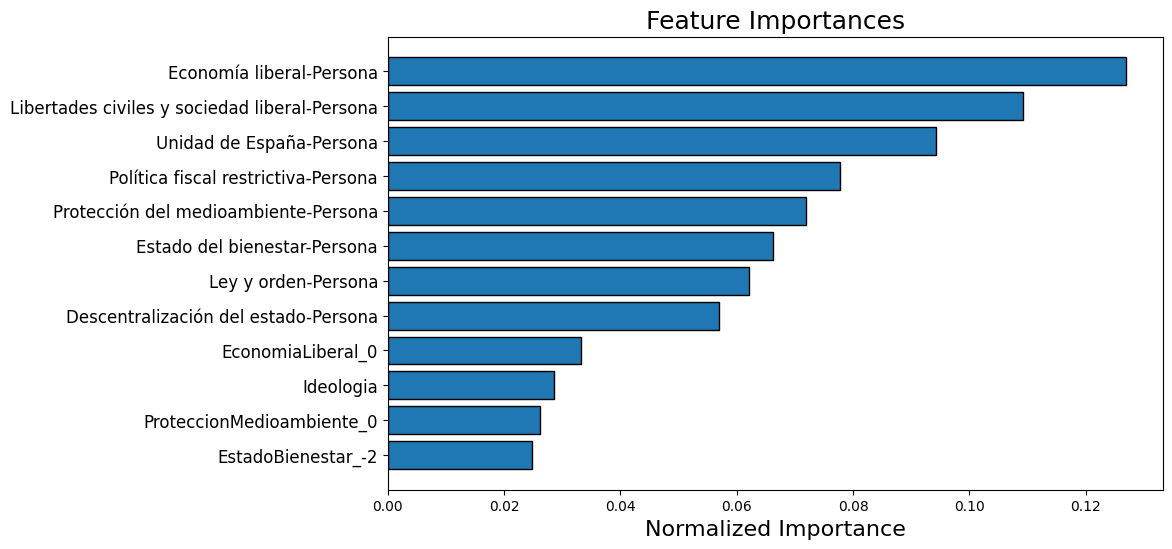

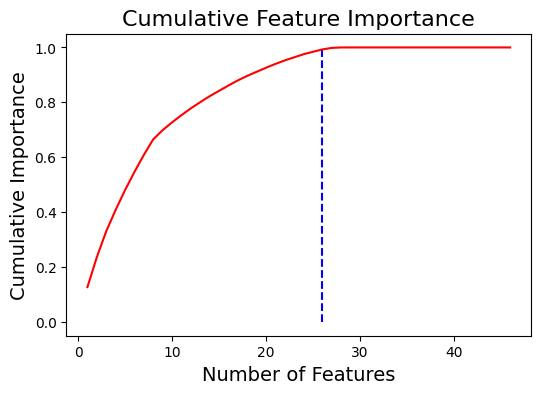

26 features required for 0.99 of cumulative importance


In [0]:
# Pass in the appropriate parameters
fs.identify_zero_importance(task = 'classification', 
                            eval_metric = 'auc', 
                            n_iterations = 10, 
                             early_stopping = True)

# list of zero importance features
zero_importance_features = fs.ops['zero_importance']

# plot the feature importances
fs.plot_feature_importances(threshold = 0.99, plot_n = 12)

In [0]:
fs.identify_low_importance(cumulative_importance = 0.99)


25 features required for cumulative importance of 0.99 after one hot encoding.
21 features do not contribute to cumulative importance of 0.99.



In [0]:
fs.identify_all(selection_params = {'missing_threshold': 0.6,    
                                    'correlation_threshold': 0.98, 
                                    'task': 'classification',    
                                    'eval_metric': 'auc', 
                                    'cumulative_importance': 0.99})

0 features with greater than 0.60 missing values.

5 features with a single unique value.

2 features with a correlation magnitude greater than 0.98.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[14]	valid_0's auc: 0.423571
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	valid_0's auc: 0.297143
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[2]	valid_0's auc: 0.391429
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	valid_0's auc: 0.412143
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[13]	valid_0's auc: 0.280714
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[7]	valid_0's auc: 0.260714
Training until validation scores don't improve for 100 ro

5 features with a single unique value.



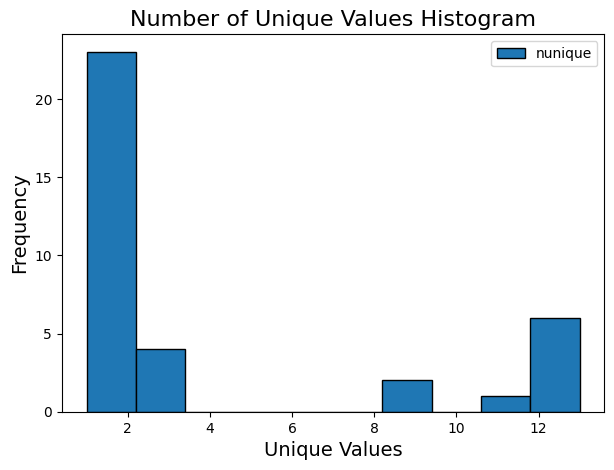

In [0]:
fs.identify_single_unique()
fs.plot_unique()

In [0]:
# Remove the features from all methods (returns a df)
train_removed = fs.remove(methods = 'all')

['collinear', 'zero_importance', 'low_importance', 'missing', 'single_unique'] methods have been run

Removed 23 features.


In [0]:
columnsRemovedFS = fs.removed_features

In [0]:
train_removed_all = fs.remove(methods = 'all', keep_one_hot=False)

['collinear', 'zero_importance', 'low_importance', 'missing', 'single_unique'] methods have been run

Removed 34 features including one-hot features.


In [0]:
columnsRemoveAllFS = fs.removed_features

Limpieza final del dataset

In [0]:
#reemplazar los valores vacios "empty string" por NaN
df = df.replace(r'^\s*$', np.NaN, regex=True)

In [0]:
print('Valores con Nan en df ' + str(df.isna().sum().sum()))
print('Valores con Nan en dfPredecir ' + str(dfPredecir.isna().sum().sum()))

Valores con Nan en df 0
Valores con Nan en dfPredecir 0


In [0]:
#columnas con Nan

nan_values = df.isna()
nan_columns = nan_values.any()

columns_with_nan = df.columns[nan_columns].tolist()
print(columns_with_nan)

[]


In [0]:
#hacer shuffle
df = df.reindex(np.random.permutation(df.index))
dfPredecir = dfPredecir.reindex(np.random.permutation(dfPredecir.index))

#separar correo y guardarlo
correosPrediccion = dfPredecir['Correo']
dfPredecir.drop(['Correo'],axis=1,inplace=True)


#separar propuesta y guardarlo
propuestaPrediccion = dfPredecir['Propuesta']
dfPredecir.drop(['Propuesta'],axis=1,inplace=True)


Procesar el texto con LDA (opcional)

In [0]:
#hacer LDA de contenido y/o resumen


Analisis de los datos

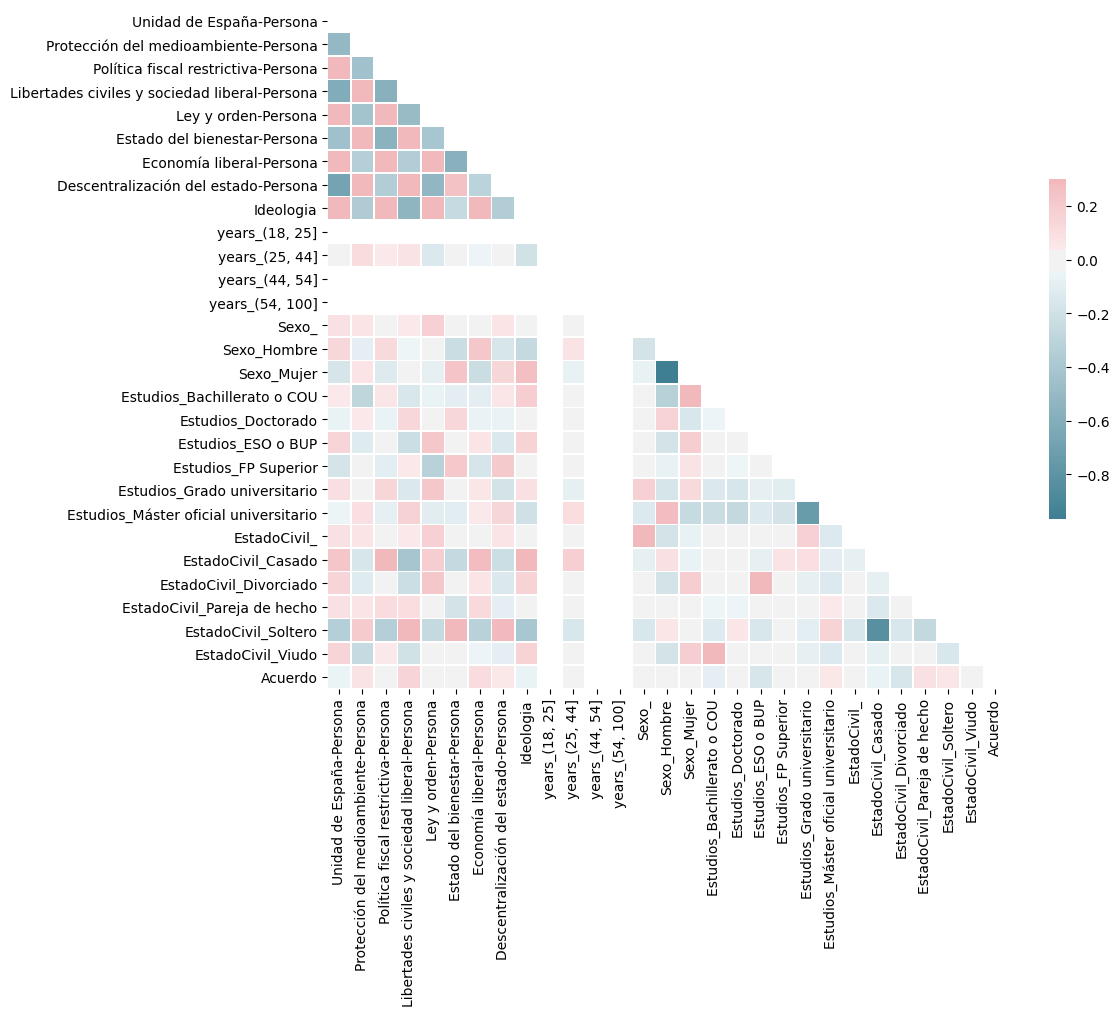

In [0]:
#cuadro guapo de colores

import seaborn as sns
# Mostrar matriz de correlación de variables
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
# Pista: explore plt.matshow y corr() de un dataframe

Comenzar con los modelos de entrenamiento

In [0]:
df.describe()

,Unidad de España-Persona,Protección del medioambiente-Persona,Política fiscal restrictiva-Persona,Libertades civiles y sociedad liberal-Persona,Ley y orden-Persona,Estado del bienestar-Persona,Economía liberal-Persona,Descentralización del estado-Persona,Ideologia,"years_(18, 25]","years_(25, 44]","years_(44, 54]","years_(54, 100]",Sexo_,Sexo_Hombre,Sexo_Mujer,Estudios_Bachillerato o COU,Estudios_Doctorado,Estudios_ESO o BUP,Estudios_FP Superior,Estudios_Grado universitario,Estudios_Máster oficial universitario,EstadoCivil_,EstadoCivil_Casado,EstadoCivil_Divorciado,EstadoCivil_Pareja de hecho,EstadoCivil_Soltero,EstadoCivil_Viudo,Acuerdo
count,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.0,423.000000,423.0,423.0,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000
mean,3.362490,3.834515,2.594957,3.540583,3.200158,3.286840,2.767533,2.330969,6.162727,0.0,0.014184,0.0,0.0,0.014184,0.702128,0.283688,0.042553,0.056738,0.014184,0.028369,0.309693,0.548463,0.014184,0.297872,0.014184,0.042553,0.617021,0.014184,2.458629
std,1.310805,0.864084,0.971612,1.165987,0.995181,0.837945,0.962880,1.159306,1.348691,0.0,0.118391,0.0,0.0,0.118391,0.457865,0.451321,0.202087,0.231614,0.118391,0.166221,0.462914,0.498235,0.118391,0.457865,0.118391,0.202087,0.486689,0.118391,0.821838
min,1.000000,1.666667,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,3.333333,1.666667,3.000000,2.666667,3.000000,2.000000,1.500000,6.166667,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,3.666667,3.666667,2.666667,3.666667,3.333333,3.333333,2.666667,2.000000,6.166667,0.0,0.000000,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000
75%,4.333333,4.666667,3.333333,4.666667,4.000000,3.666667,3.666667,3.000000,6.166667,0.0,0.000000,0.0,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,3.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,9.000000,0.0,1.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000


In [0]:
#comparar los data set
print("Original: " + str(df.drop('Acuerdo', axis=1).shape))
print("Feature Selector: " + str(train_removed.shape))
print("Feature Selector Remove one hot: " + str(train_removed_all.shape))

Original: (423, 36)
Feature Selector: (423, 31)
Feature Selector Remove one hot: (423, 20)


In [0]:
#STOP

In [0]:
#separar X e y
modeloUsar = 1 #1 todas las features, #2 feature remove normal, #3 feature removea all

if modeloUsar == 1:
  X = df.drop('Acuerdo', axis=1)
elif modeloUsar == 2:
  X = train_removed
  dfPredecir = dfPredecir.drop(columnsRemovedFS, axis=1)
elif modeloUsar == 3:
  X = train_removed_all
  dfPredecir = dfPredecir.drop(columnsRemovedAllFS, axis=1)
else:
  X = df.drop('Acuerdo', axis=1)

y = df['Acuerdo']

In [0]:
# Split the 'features' and 'income' data into training and testing sets, .2, .3, .33
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=0)

In [0]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((338, 36), (85, 36), (338,), (85,))

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [0]:
#Configurar estos dos números cambiandolos a mano
type_of_model = 0


model_text = ""
model = np.NAN

print("Comparando modelos:")

for i in range(6):
    type_of_model = i + 1
    if type_of_model == 1:
        model = RandomForestClassifier()
        model_text = "Random Forest"
    if type_of_model == 2:
        model = LinearDiscriminantAnalysis()
        model_text = "LinearDiscriminantAnalysis"
    elif type_of_model == 3:
        model = KNeighborsClassifier()
        model_text = "KNeighborsClassifier"
    elif type_of_model == 4:
        model = SVC()
        model_text = "SVC" #0.476
    elif type_of_model == 5:
        model = GaussianNB()
        model_text = "GaussianNB" #0.19
    elif type_of_model == 6:
        model = DecisionTreeClassifier()
        model_text = "DecisionTreeClassifier"
    else: 
        model = RandomForestClassifier()
        model_text = "Random Forest"



    # Entrenar el clasificador con las los datos de entrenamiento y las feature
    # Una línea de código
    model.fit(X_train, y_train)

    # Aplicar classif.predict sobre los datos X de test (X_test)
    # Una línea de código
    y_pred = model.predict(X_test)

    #imprimir prediction
    print(model_text + " - Accuracy Score: " + str(accuracy_score(y_test, y_pred)))

Comparando modelos:
Random Forest - Accuracy Score: 0.7764705882352941
LinearDiscriminantAnalysis - Accuracy Score: 0.6352941176470588
KNeighborsClassifier - Accuracy Score: 0.7529411764705882
SVC - Accuracy Score: 0.7058823529411765
GaussianNB - Accuracy Score: 0.7058823529411765
DecisionTreeClassifier - Accuracy Score: 0.7764705882352941


In [0]:
#Configurar estos dos números cambiandolos a mano
type_of_model = 1 # 1: Random Forestn, 2: LinearDiscriminantAnalysis, 3: KNeighborsClassifier, 4: SVC, 5:Redes Bayesianas GaussianNB, 6:DecisionTreeClassifier

model_text = "Random Forest" #0.535"
model = np.NaN

if type_of_model == 1:
  model = RandomForestClassifier()
  model_text = "Random Forest"
elif type_of_model == 2:
    model = LinearDiscriminantAnalysis()
    model_text = "LinearDiscriminantAnalysis" #0.392
elif type_of_model == 3:
    model = KNeighborsClassifier()
    model_text = "KNeighborsClassifier" #0.488
elif type_of_model == 4:
    model = SVC()
    model_text = "SVC" #0.476
elif type_of_model == 5:
    model = GaussianNB()
    model_text = "GaussianNB" #0.19
elif type_of_model == 6:
    model = DecisionTreeClassifier()
    model_text = "DecisionTreeClassifier" #0.46
else: 
    model = RandomForestClassifier()
    model_text = "Random Forest"


# Entrenar el clasificador con las los datos de entrenamiento y las feature
# Una línea de código
model.fit(X_train, y_train)

# Aplicar classif.predict sobre los datos X de test (X_test)
# Una línea de código
y_pred = model.predict(X_test)

#imprimir prediction
print(model_text + " - Accuracy Score: " + str(accuracy_score(y_test, y_pred)))

Random Forest - Accuracy Score: 0.788235294117647


In [0]:
'''
#probando random hiper parametros

model = RandomForestClassifier()

from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 17, 20, 30, 40, 50, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

#usamos este modelo para entender los rangos optimos de los hiperparametros
# Use the random grid to search for best hyperparameters

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
best_tree = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=27, n_jobs = -1)
# Fit the random

#entrenamos el modelo para probar el rango de parametros pasados
best_tree.fit(X_train, y_train)

#vemos los mejores parámetros
best_tree.best_estimator_
'''

"\n#probando random hiper parametros\n\nmodel = RandomForestClassifier()\n\nfrom sklearn.model_selection import RandomizedSearchCV\n# Number of trees in random forest\nn_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]\n# Number of features to consider at every split\nmax_features = ['auto', 'sqrt']\n# Maximum number of levels in tree\nmax_depth = [int(x) for x in np.linspace(10, 110, num = 11)]\nmax_depth.append(None)\n# Minimum number of samples required to split a node\nmin_samples_split = [2, 5, 10]\n# Minimum number of samples required at each leaf node\nmin_samples_leaf = [1, 2, 4]\n# Method of selecting samples for training each tree\nbootstrap = [True, False]\n# Create the random grid\nrandom_grid = {'n_estimators': n_estimators,\n               'max_features': max_features,\n               'max_depth': max_depth,\n               'min_samples_split': min_samples_split,\n               'min_samples_leaf': min_samples_leaf,\n               'bootstrap

In [0]:
'''
bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=60, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=1400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False
'''

"\nbootstrap=False, ccp_alpha=0.0, class_weight=None,\n                       criterion='gini', max_depth=60, max_features='sqrt',\n                       max_leaf_nodes=None, max_samples=None,\n                       min_impurity_decrease=0.0, min_impurity_split=None,\n                       min_samples_leaf=2, min_samples_split=10,\n                       min_weight_fraction_leaf=0.0, n_estimators=1400,\n                       n_jobs=None, oob_score=False, random_state=None,\n                       verbose=0, warm_start=False\n"

In [0]:
'''
#optimizar con gridsearch, super explotarorio

#probar varios rangos usando Grid Search CV
params = {
    'bootstrap': [True,False],
    'max_depth': [45, 50, 55, 60, 65],
    #'max_features': [3, 4, 5],
    'min_samples_leaf': [2,3,4,5],
    'min_samples_split': [8,10,12,14,15],
    'n_estimators': [1300,1400,1500]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=27)
best_tree = GridSearchCV(estimator=model, param_grid=params, cv=skf, n_jobs=-1, verbose=1)

#entrenamos el modelo para probar el rango de parametros pasados
best_tree.fit(X_train, y_train)

#vemos los mejores parámetros
best_tree.best_estimator_
'''

"\n#optimizar con gridsearch, super explotarorio\n\n#probar varios rangos usando Grid Search CV\nparams = {\n    'bootstrap': [True,False],\n    'max_depth': [45, 50, 55, 60, 65],\n    #'max_features': [3, 4, 5],\n    'min_samples_leaf': [2,3,4,5],\n    'min_samples_split': [8,10,12,14,15],\n    'n_estimators': [1300,1400,1500]\n}\n\nskf = StratifiedKFold(n_splits=5, shuffle=True, random_state=27)\nbest_tree = GridSearchCV(estimator=model, param_grid=params, cv=skf, n_jobs=-1, verbose=1)\n\n#entrenamos el modelo para probar el rango de parametros pasados\nbest_tree.fit(X_train, y_train)\n\n#vemos los mejores parámetros\nbest_tree.best_estimator_\n"

In [0]:
'''
RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=60, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=1300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
'''

"\nRandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,\n                       criterion='gini', max_depth=60, max_features='sqrt',\n                       max_leaf_nodes=None, max_samples=None,\n                       min_impurity_decrease=0.0, min_impurity_split=None,\n                       min_samples_leaf=3, min_samples_split=8,\n                       min_weight_fraction_leaf=0.0, n_estimators=1300,\n                       n_jobs=None, oob_score=False, random_state=None,\n                       verbose=0, warm_start=False)\n"

In [0]:
#usando la libreria classification score

from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.90      0.64      0.75        14
           2       0.33      0.18      0.24        11
           3       0.81      0.93      0.87        60

    accuracy                           0.79        85
   macro avg       0.68      0.59      0.62        85
weighted avg       0.76      0.79      0.77        85



Predecir para los que seleccionamos las propuestas de ley nuevas#separ

In [0]:
#hacer la predicción
prediccion = model.predict(dfPredecir)

In [0]:
dfPrediccion = pd.DataFrame(columns=['Correo', 'Propuesta', 'AcuerdoPredicción'])
dfPrediccion["Correo"] = correosPrediccion
dfPrediccion["Propuesta"] = propuestaPrediccion
dfPrediccion["AcuerdoPredicción"] = prediccion

In [0]:
dfPrediccion.head(21)

,Correo,Propuesta,AcuerdoPredicción
9,laseiras@gmail.com,Propuesta4,3
6,laseiras@gmail.com,Propuesta3,3
4,dmedina82@gmail.com,Propuesta2,3
1,dmedina82@gmail.com,Propuesta1,3
11,f.gar.garcia@gmail.com,Propuesta4,3
14,f.gar.garcia@gmail.com,Propuesta5,3
10,dmedina82@gmail.com,Propuesta4,3
2,f.gar.garcia@gmail.com,Propuesta1,3
17,f.gar.garcia@gmail.com,Propuesta6,3
12,laseiras@gmail.com,Propuesta5,3
